# Tarea 2
## Francisco Javier Peralta Ramírez

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

import warnings
sp.init_printing()
warnings.filterwarnings('ignore')

In [60]:
def nag(f, gradf, x0, nIter, alpha, eta):
    assert alpha > 0 and eta > 0#positive step size
    a, e, x = alpha, eta, x0
    #primer paso es desenso de gradiente...
    p = gradf(x)
    fx = [f(x)]
    x = x - a * p
    #empieza NAG
    fx.append(f(x))
    for i in range(nIter - 1): #ya hicimos la primera iteracion...
        xn = x - a * p #tomamos el paso anterior
        gt = gradf(xn)
        p = e * p + gt #nueva dir
        x = xn -  a * p
        fx.append(f(x))
    return np.array(fx), x

In [61]:
def adagrad(f, gradf, x0, nIter, alpha, epsilon = 0.001):
    x = x0
    g2 = np.zeros_like(x)
    fx = [f(x)]
    for i in range(nIter):
        g = gradf(x)
        g2 += g**2 #suma cuadrada de gradientes
        n = alpha / np.sqrt(g2 + epsilon)
        x = x - n * g
        fx.append(f(x))
    return np.array(fx), x

In [68]:
def adam(f, gradf, x0, nIter, alpha, beta = (0.9, 0.999), epsilon = 1E-8):
    x = x0
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    fx = [f(x)]
    
    for i in range(nIter):
        g = gradf(x)
        m = beta[0] * m + (1 - beta[0]) * g    #decaying avg momentum
        v = beta[1] * v + (1 - beta[1]) * g**2 #decaying velocity
        #bias corrected first and second moments
        mh = m / ( 1 - beta[0])
        vh = v / ( 1 - beta[1])
        x = x - alpha * mh / (np.sqrt(vh) + epsilon)
        fx.append(f(x))
    return fx, x

Codificamos la función rosembrock como un simple **for**

In [69]:
def rosenbrock(x):
    fx = 0
    for i in range(len(x) - 1):
        fx += 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return fx

Como la función *rosenbrock* admite cualquier tipo (i.e. no se hace chequeo de tipos) podemos pasar simbolos de *sympy*

In [70]:
x = sp.symbols('x1:3')
rosenbrock(x)

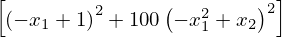

In [71]:
ros = sp.Matrix([rosenbrock(x)])
ros

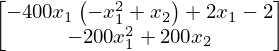

In [72]:
jacRos = ros.jacobian(x).T
jacRos

Podemos evaluar el resultado del gradiente usando la función **subs** la cual substituye las variables por valores, esta requiere un parámetro de la forma ***[ (old, new), ... ]*** donde *old* es la variable a remplazar y *new* el valor.

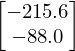

In [73]:
x0 = [-1.2, 1]
evalJ = jacRos.subs([(x[i], x0[i]) for i in range(len(x0))])
evalJ

Podemos juntar todo esto para crear una función que regresa el gradiente

In [74]:
def sym_grad(f, x):
    x_s = sp.symbols('x0:{}'.format(len(x)))
    mtx = sp.Matrix([f(x_s)])
    jac = mtx.jacobian(x_s)
    evl = jac.subs([(x_s[i], x[i]) for i in range(len(x0))])
    return np.array( [float(v) for v in evl])
sym_grad(rosenbrock, x0) #comprobamos funcionamiento

#mucho mas rapido con lamdify
def sym_grad2(f, k):
    x_s = sp.symbols('x0:{}'.format(k))
    mtx = sp.Matrix([f(x_s)])
    jac = mtx.jacobian(x_s)
    jac_f  = [sp.lambdify(x_s, jac[i]) for i in range(k)]
    def __gradient(x):
        return np.array([ jac_f[i](*x) for i in range(k)])
    return __gradient

def sym_grad_batch(f, x, syms):
    pass

In [75]:
rosenbrock_grad = sym_grad2(rosenbrock, len(x0))

In [76]:
nag(rosenbrock, rosenbrock_grad, x0, 10, 0.001, .5)[0]

array([24.2       ,  5.35291158, 19.52528548,  4.58113728,  4.75316463,
        6.15174762,  3.75940649,  4.19228526,  3.68422386,  3.75607264,
        3.64109028])

In [77]:
adagrad(rosenbrock, rosenbrock_grad, x0, 10, 1)[0]

array([ 24.2       , 385.59997303,  20.18288904,  45.93722297,
        81.80565154,   3.47473215,   3.44412215,   3.42676314,
         3.41431123,   3.40459526,   3.39600965])

In [78]:
adam(rosenbrock, rosenbrock_grad, x0, 10, .1)[0]

Comparamos los resultados de **NAG, ADAGRAD, ADAM** para *Rosenbrock* con $n = 2$ y $x_0 = [-1.2, 1]$

In [79]:
def plot_res(nag_res, adagrad_res, adam_res):
    f, ax = plt.subplots(1, 2, figsize=(24, 8))

    ax[0].plot(nag_res[0], label="NAG")
    ax[0].plot(adagrad_res[0], label="ADAGRAD")
    ax[0].plot(adam_res[0], label="ADAM")
    ax[0].legend()

    ax[1].plot(nag_res[0])
    ax[1].plot(adagrad_res[0])
    ax[1].plot(adam_res[0])
    ax[1].set_xlim(n_iter - 10, n_iter)
    ax[1].set_ylim(-0.0001, nag_res[0][-1] * 1.5)
    plt.show()

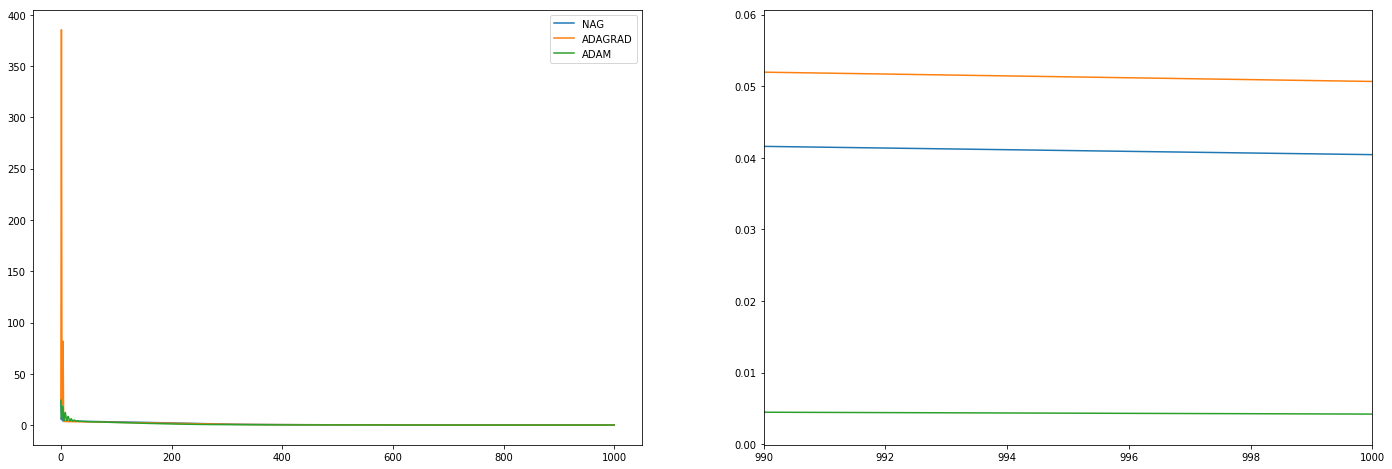

NAG: [0.79910435 0.63766357]	ADAGRAD: [0.77514237 0.59981835]	ADAM: [0.93529014 0.87454946]
CPU times: user 334 ms, sys: 11.7 ms, total: 346 ms
Wall time: 344 ms


In [80]:
%%time
x0 = [-1.2, 1]
n_iter = 1000
rosenbrock_grad = sym_grad2(rosenbrock, len(x0))
nag_res = nag(rosenbrock, rosenbrock_grad, x0, n_iter, 0.001, 0.2)
adagrad_res = adagrad(rosenbrock, rosenbrock_grad, x0, n_iter, 1)
adam_res = adam(rosenbrock, rosenbrock_grad, x0, n_iter, 0.1)

plot_res(nag_res, adagrad_res, adam_res)
print("NAG: {0}\tADAGRAD: {1}\tADAM: {2}".format(nag_res[-1], adagrad_res[-1] , adam_res[-1]))

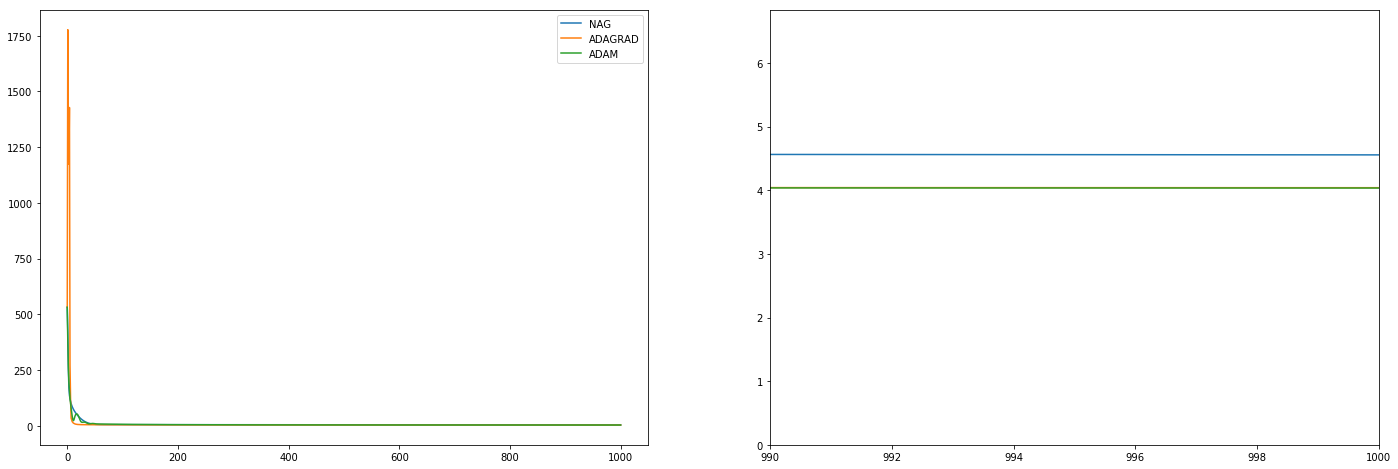

NAG: [-0.98945451  0.98909529  0.98339021  0.96963958  0.94154387  0.8872403
  0.78763609  0.62061888  0.38493011  0.14508225]	ADAGRAD: [-0.99235655  0.99481155  0.99468832  0.99194524  0.98526352  0.97148574
  0.94413746  0.8914056   0.79436215  0.63009965]	ADAM: [-0.99243197  0.99496001  0.99496587  0.9924557   0.98619166  0.97313098
  0.94714521  0.8969195   0.80422369  0.64596234]
CPU times: user 461 ms, sys: 6.68 ms, total: 468 ms
Wall time: 466 ms


In [81]:
%%time
x0 = np.ones((10))
x0[0] = x0[-2] = -1.2
rosenbrock_grad = sym_grad2(rosenbrock, len(x0))
n_iter = 1000
nag_res = nag(rosenbrock, rosenbrock_grad, x0, n_iter, 0.0001, 0.5)
adagrad_res = adagrad(rosenbrock, rosenbrock_grad, x0, n_iter, 1)
adam_res = adam(rosenbrock, rosenbrock_grad, x0, n_iter, 0.1)

plot_res(nag_res, adagrad_res, adam_res)
print("NAG: {0}\tADAGRAD: {1}\tADAM: {2}".format(nag_res[-1], adagrad_res[-1] , adam_res[-1]))

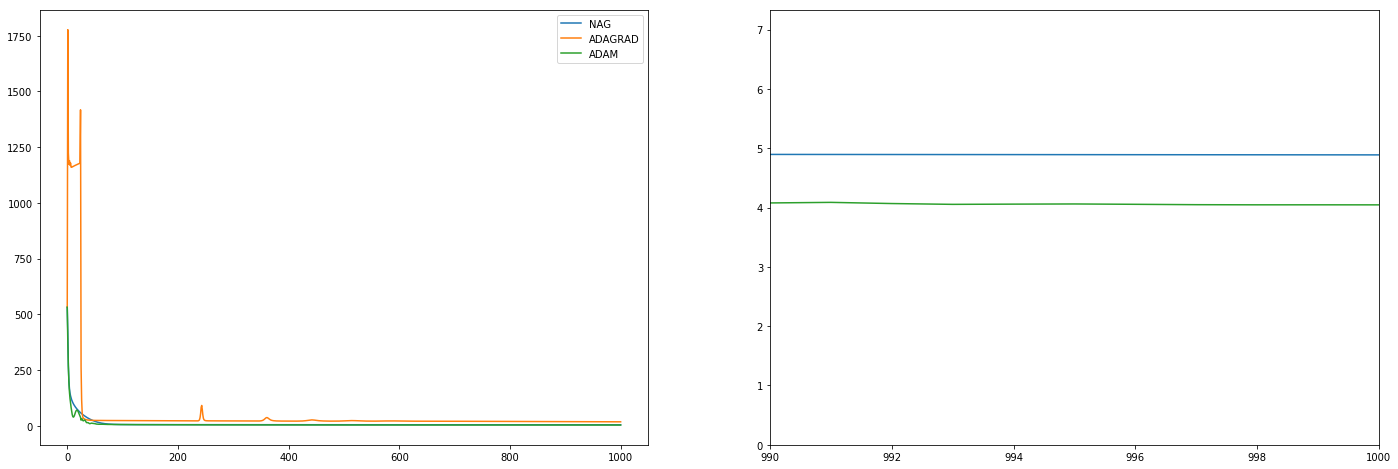

NAG: [-0.9932861   0.99665107  0.99833032  0.99916774  0.9995852   0.99979328
  0.99989698  0.99994866  0.99997441  0.99998725  0.99999365  0.99999683
  0.99999842  0.99999921  0.99999961  0.9999998   0.9999999   0.99999995
  0.99999997  0.99999999  0.99999999  0.99999999  0.99999998  0.99999996
  0.99999992  0.99999983  0.99999967  0.99999933  0.99999867  0.99999734
  0.9999947   0.99998942  0.99997888  0.99995784  0.99991583  0.99983197
  0.99966457  0.99933046  0.99866375  0.99733397  0.99468433  0.98941524
  0.97897862  0.95847009  0.91880331  0.84446556  0.71361619  0.51008429
  0.26114486  0.06558935]	ADAGRAD: [-9.93286101e-01  9.96651075e-01  9.98330320e-01  9.99167738e-01
  9.99585202e-01  9.99793276e-01  9.99896977e-01  9.99948656e-01
  9.99974407e-01  9.99987234e-01  9.99993615e-01  9.99996774e-01
  9.99998305e-01  9.99998985e-01  9.99999161e-01  9.99998931e-01
  9.99998195e-01  9.99996614e-01  9.99993451e-01  9.99987232e-01
  9.99975061e-01  9.99951218e-01  9.99905072e-01  9

In [82]:
%%time
x0 = np.ones((50))
x0[0] = x0[-2] = -1.2
rosenbrock_grad = sym_grad2(rosenbrock, len(x0))
n_iter = 1000
nag_res = nag(rosenbrock, rosenbrock_grad, x0, n_iter, 0.0001, 0.2)
adagrad_res = adagrad(rosenbrock, rosenbrock_grad, x0, n_iter, 1)
adam_res = adam(rosenbrock, rosenbrock_grad, x0, n_iter, 0.1)

plot_res(nag_res, adagrad_res, adam_res)
print("NAG: {0}\tADAGRAD: {1}\tADAM: {2}".format(nag_res[-1], adagrad_res[-1] , adam_res[-1]))

In [83]:
data = np.load('data.npy')

In [84]:
def radial_gauss(x, mu, sigma, lib=sp):
    expv = (x - mu)**2 / (2 * sigma**2)
    return lib.exp(-expv)

def radial_fit(x, mu, sigma, c, lib=sp):
    val = c[0]
    for i in range(len(mu)):
        val += c[i+1] * radial_gauss(x, mu[i], sigma[i], lib)
    return val

def radial_err(x, y, mu, sigma, c, lib=sp):
    err = 0
    for i in range(len(y)):
        err += (radial_fit(x[i], mu, sigma, c, lib) - y[i])**2
    return err

def create_radial_err_fun(x, y, msc):
    def fun(val):
        k = int(np.floor(len(msc)/3))
        mu, sigma, c = msc[:k], msc[k:2*k], msc[2*k:]
        errf = radial_err(x, y, mu, sigma, c, sp)
        errL = sp.lambdify(msc, errf)
        return errL(*val)
    return fun

In [85]:
radial_err(data[:10, 0], data[:10, 1], np.array([0, 1, 2]), np.array([1, 2, 3]), np.array([0, 1, 2, 3]))

In [86]:
k = 3
c = sp.symbols('c0:{}'.format(k + 1))
mu = sp.symbols('m0:{}'.format(k))
sigma = sp.symbols('s0:{}'.format(k))

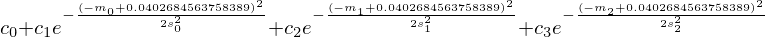

In [87]:
radial_fit(data[1:2, 0][0], mu ,sigma, c, sp)

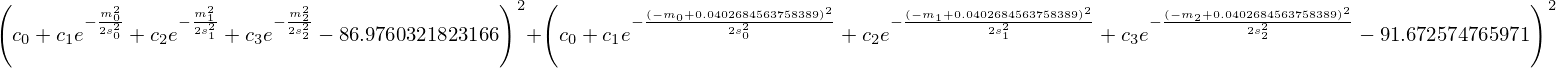

In [89]:
radial_err(data[:2, 0], data[:2, 1], mu ,sigma, c, sp)

In [90]:
def radial_err_pdif(x, y, mu, sigma, c):
        """mask: a bookean array that indicates the 
        symbols we need to derive with respect to.
        Derivatives wil be wrt mu, then sigma then c"""
        fun = radial_err(x, y, mu, sigma, c, sp) #use sympy
        partials = [0] * (len(mu) * 3 + 1)
        k = 0
        for i in range(len(mu)):
            partials[k] = sp.diff(fun, mu[i])
            k +=1
        for i in range(len(sigma)):
            partials[k] = sp.diff(fun, sigma[i])
            k +=1
        for i in range(len(c)):
            partials[k] = sp.diff(fun, c[i])
            k +=1
        return partials
    
def create_radial_err_pdif_fun(x, y, msc, batch=20):
    p = [i for i in range(len(data))]
    def fun(val):
        idxs = np.random.choice(p, batch)
        k = int(np.floor(len(msc)/3))
        mu, sigma, c = msc[:k], msc[k:2*k], msc[2*k:]
        errdif  =  radial_err_pdif(x[idxs], y[idxs], mu, sigma, c)
        errdifL = [sp.lambdify(msc, errdif[i]) for i in range(len(val))]
        return np.array([errdifL[i](*val) for i in range(len(val))])
    return fun

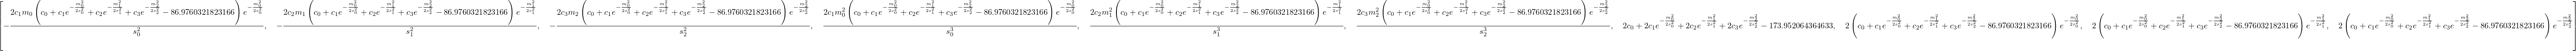

In [91]:
radial_err_pdif(data[:1, 0], data[:1, 1], mu, sigma, c)

In [121]:
%%time
x, y = data[:, 0], data[:, 1]
msc = (mu + sigma + c)
gradf = create_radial_err_pdif_fun(x, y, msc, batch=30)
f = create_radial_err_fun(x, y, msc)
cm = data[:,1].mean()
mus = np.random.choice(6, 3, replace=False)
mus.sort()
x0 = np.append(mus, [1, 1, 1, 0, cm, cm, cm])
print(x0)

[ 0.          3.          5.          1.          1.          1.
  0.         79.57087455 79.57087455 79.57087455]
CPU times: user 502 µs, sys: 72 µs, total: 574 µs
Wall time: 525 µs


(array([266284.27393984, 255393.67226641, 241222.050138  , 231184.48947012,
       223256.53748947, 218705.49993938, 214573.02001193, 210706.02615942,
       205995.33440404, 203843.67669426, 201790.3804976 , 200651.92511806,
       201560.25684285, 200153.22195475, 195936.54934158, 193755.23356465,
       192219.02746915, 191336.73355864, 190948.28888877, 190303.52935974,
       189134.88810037, 187130.09826306, 185784.39043419, 184020.99515606,
       182058.83537214, 180766.63782112, 180466.23819619, 180500.20125545,
       179660.27134775, 178980.61729965, 176622.56720251, 177047.38687358,
       174953.5682275 , 173284.2766334 , 171379.14458265, 171543.78852175,
       171789.91203009, 171264.50352799, 170234.02889476, 166193.48636144,
       165693.88475481, 164380.17878576, 163965.92128772, 163329.74631002,
       162781.97386974, 163197.48368161, 161604.29532352, 160090.72463822,
       159566.41557644, 159058.28203035, 157486.99917676, 157950.80100335,
       156604.0394397 , 

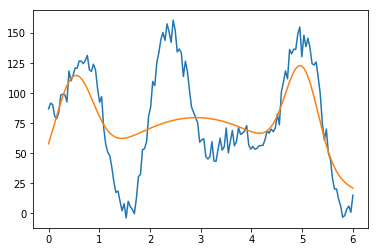

CPU times: user 9min 55s, sys: 1.47 s, total: 9min 56s
Wall time: 9min 57s


In [125]:
%%time
nag_res = nag(f, gradf, x0, 100, 0.000001, 0.1)
print(nag_res)
# nag_res[1]
plt.plot(x, y)
plt.plot(x, radial_fit(x, nag_res[1][:3], nag_res[1][3:6], nag_res[1][6:], np))
plt.show()

(array([266284.27393984, 237228.05775963, 222992.2299599 , 222161.01220804,
       215265.25917153, 210877.26432612, 207070.72982208, 203872.16650213,
       203295.58400269, 203565.03604386, 201143.75907744, 203205.48142814,
       200509.36215071, 198810.65146768, 197144.85576597, 195809.49338088,
       196462.51705116, 194072.88231535, 191623.67140962, 190674.8511467 ,
       189803.99175591, 189748.89927658, 188972.04729117, 187590.86064677,
       186816.76515316, 184877.50191325, 184303.85629103, 184277.52554712,
       182594.85498466, 180766.12554411, 180020.67340146, 178853.82995274,
       177160.78663129, 177098.13298907, 176793.0851384 , 175553.98331131,
       173982.99514804, 173566.15615313, 173300.12978848, 171472.01161759,
       171112.95502657, 170826.24237205, 171092.25916511, 169452.20805715,
       168503.22092271, 168254.49018489, 167297.95915294, 166800.54948101,
       166272.48889631, 166474.87070693, 166055.05231591, 165469.14151172,
       165428.24884307, 

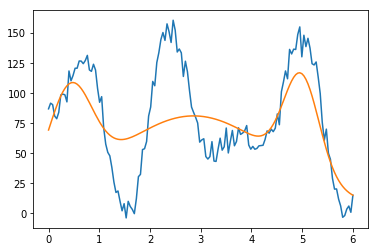

CPU times: user 9min 40s, sys: 496 ms, total: 9min 41s
Wall time: 9min 50s


In [128]:
%%time
adagrad_res = adagrad(f, gradf, x0, 100, .1)
print(adagrad_res)
plt.plot(x, y)
plt.plot(x, radial_fit(x, adagrad_res[1][:3], adagrad_res[1][3:6], adagrad_res[1][6:], np))
plt.show()

([266284.27393984055, 237275.0174314012, 221363.83672828216, 208755.76443652445, 206956.93188188577, 203795.02318688945, 198476.1544171718, 205907.60494384397, 196612.85286532986, 187433.8778057401, 192327.55672663762, 192120.75159598136, 198081.27931882298, 193511.53229468013, 178269.92113797774, 161994.8866415828, 159331.90227808824, 161829.65980886915, 162820.03243990912, 160695.3602348147, 157415.06301630702, 154298.25600504098, 153410.77608585844, 150118.2797221103, 145238.18958407085, 148986.4173886505, 162379.42720650436, 175289.80097198216, 164881.0219756355, 160980.46582239599, 169077.0977972775, 180944.70529841667, 179959.83371287372, 159117.40386810896, 147737.47523277815, 144311.85606686337, 148287.633622988, 158393.30429084008, 165883.48804104497, 163931.88151128392, 154479.60879885283, 148920.4925275296, 149254.88869731105, 151838.052591104, 153505.47600814726, 154952.21364005588, 152936.1249320517, 146829.22515755807, 142804.1528179216, 145308.34810684583, 148977.8800543

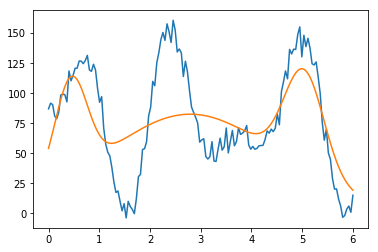

CPU times: user 5min 8s, sys: 920 ms, total: 5min 9s
Wall time: 5min 10s


In [127]:
%%time
adam_res = adam(f, gradf, x0, 50, 0.1)
print(adam_res)
plt.plot(x, y)
plt.plot(x, radial_fit(x, adam_res[1][:3], adam_res[1][3:6], adam_res[1][6:], np))
plt.show()

In [135]:
%%time
k = 5
c = sp.symbols('c0:{}'.format(k + 1))
mu = sp.symbols('m0:{}'.format(k))
sigma = sp.symbols('s0:{}'.format(k))
x, y = data[:, 0], data[:, 1]
msc = (mu + sigma + c)
gradf = create_radial_err_pdif_fun(x, y, msc, batch=30)
f = create_radial_err_fun(x, y, msc)
cm = data[:,1].mean()
mus = np.random.choice(6, k, replace=False)
mus.sort()
x0 = np.append(mus, [1]*k + [0]+ [cm]*k)
print(x0, len(x0))

[ 1.          2.          3.          4.          5.          1.
  1.          1.          1.          1.          0.         79.57087455
 79.57087455 79.57087455 79.57087455 79.57087455] 16
CPU times: user 1.23 ms, sys: 505 µs, total: 1.74 ms
Wall time: 1.34 ms


(array([1362010.49280006,  824663.17954404,  330811.45303764,
        226768.70990796,  152278.25928182,  103753.99376652,
         80878.34211413,   73927.10043709,   71494.55850709,
         68067.4254204 ,   64965.91399037,   65050.97486156,
         69039.61850542,   65047.87173821,   62677.02711528,
         63255.08776265,   64971.92904164,   63990.51999615,
         63220.58606036,   63441.43744268,   64513.53399836,
         65318.19786357,   63655.59922847,   61893.04902912,
         62357.64396579,   62103.6495083 ,   64071.21556999,
         61599.30106765,   62785.56845101,   61691.05165291,
         62010.84784313,   62272.31737896,   61826.72175439,
         62452.1178849 ,   62547.08480156,   62289.87861772,
         63925.03886095,   62968.33758678,   61737.35280702,
         61970.86259188,   62162.82100312,   62763.95085717,
         63052.78788107,   63833.67816177,   63976.14494332,
         63234.78315206,   62376.03917493,   62975.18255264,
         63209.29520675

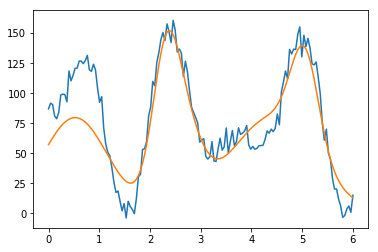

CPU times: user 18min 49s, sys: 2.13 s, total: 18min 51s
Wall time: 18min 53s


In [140]:
%%time
nag_res = nag(f, gradf, x0, 100, 0.000001, 0.1)
print(nag_res)
# nag_res[1]
plt.plot(x, y)
plt.plot(x, radial_fit(x, nag_res[1][:k], nag_res[1][k:2*k], nag_res[1][2*k:], np))
plt.show()

(array([1362010.49280006,  942759.4623551 ,  725920.53002352,
        608971.30372755,  506349.61377335,  441087.34117814,
        389256.7993106 ,  348656.14219022,  306470.01055016,
        272878.42750558,  246904.06120675,  236774.59108416,
        220518.98447099,  215232.69278204,  209519.5850294 ,
        193175.6688508 ,  175811.92720768,  165817.15604627,
        160046.87645906,  154642.74728813,  149739.06428523,
        150130.99377726,  144813.55651625,  144081.10524366,
        142019.67063505,  140601.9217045 ,  137192.30583216,
        134143.9119796 ,  132677.62989009,  130817.08503516,
        128512.23891345,  126515.54953491,  124381.69910166,
        122200.8477871 ,  121045.40955898,  118853.50009556,
        116764.94865837,  115194.3043526 ,  114360.78290449,
        112596.66706111,  111023.29846301,  109974.24923916,
        108606.57345089,  107474.75333203,  106925.04644742,
        106985.93805395,  105534.77663429,  104583.22922709,
        103493.53605686

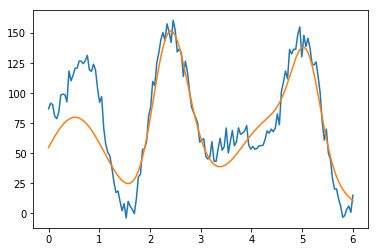

CPU times: user 18min 52s, sys: 4.03 s, total: 18min 56s
Wall time: 19min


In [141]:
%%time
adagrad_res = adagrad(f, gradf, x0, 100, .1)
print(adagrad_res)
plt.plot(x, y)
plt.plot(x, radial_fit(x, adagrad_res[1][:k], adagrad_res[1][k:2*k], adagrad_res[1][2*k:], np))
plt.show()

([3128962.950308283, 2186719.9960642, 1247556.4098026163, 678669.3350739611, 527244.522590568, 622194.1130978165, 811836.924149814, 784547.4660581744, 725184.5876369831, 612208.2690956873, 516433.69818809937, 531711.3850406054, 588706.7009698196, 632680.047581075, 616699.8209568739, 577080.1842800317, 511707.28724886174, 450782.1012845105, 389848.44657039235, 345170.66517405317, 310831.93496857036, 288557.0030172974, 271893.7685311083, 256792.14339968772, 246921.72380776406, 240742.4353084259, 232326.7264506277, 211803.69208000688, 182134.63697883114, 147454.5904048433, 118970.44252355986, 100606.08502184325, 95981.15041060369, 101339.88702807728, 106972.74673308141, 115015.58983370251, 118695.10292063304, 118634.56482826686, 113276.21173837187, 104163.62242323013, 90331.38701095525, 77174.15045818425, 68201.29013210091, 63916.47140375034, 63635.43304829274, 63806.73220813969, 64665.69586501717, 66258.45320822095, 68139.3151468317, 68552.34487511944, 68190.02109301383, 67031.6001894136

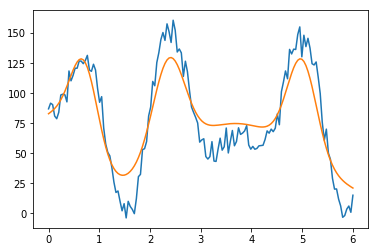

CPU times: user 33min 48s, sys: 1.14 s, total: 33min 49s
Wall time: 1h 6min 38s


In [151]:
%%time
adam_res = adam(f, gradf, x0, 100, 0.1)
print(adam_res)
plt.plot(x, y)
plt.plot(x, radial_fit(x, adam_res[1][:k], adam_res[1][k:2*k], adam_res[1][2*k:], np))
plt.show()

In [147]:
%%time
k = 7
c = sp.symbols('c0:{}'.format(k + 1))
mu = sp.symbols('m0:{}'.format(k))
sigma = sp.symbols('s0:{}'.format(k))
x, y = data[:, 0], data[:, 1]
msc = (mu + sigma + c)
gradf = create_radial_err_pdif_fun(x, y, msc, batch=30)
f = create_radial_err_fun(x, y, msc)
cm = data[:,1].mean()
mus = np.random.uniform(data[:, 0].min(), data[:, 0].max() ,k)
mus.sort()
x0 = np.append(mus, [1]*k + [0]+ [cm]*k)
print(x0, len(x0))

[ 0.13199587  2.30296464  2.36103715  3.13370348  4.02670516  4.37591838
  5.65324013  1.          1.          1.          1.          1.
  1.          1.          0.         79.57087455 79.57087455 79.57087455
 79.57087455 79.57087455 79.57087455 79.57087455] 22
CPU times: user 826 µs, sys: 231 µs, total: 1.06 ms
Wall time: 968 µs


(array([3128962.95030828, 1357898.6661499 ,  285561.72207325,
        220731.14005534,  237623.09394352,  165157.11735989,
        151215.13419889,  178155.27267693,  150167.13934184,
        129245.07122895,  131821.25620139,  128761.13086985,
        134736.13791378,  166394.50528554,  123669.62822364,
        102013.03800678,   93801.30328179,   88231.93326475,
         86281.25791752,   81020.65175853,   74668.55448656,
         73814.24441015,   81581.29609278,   71848.67910241,
         76673.99959072,   67626.66201649,   67061.92571298,
         65284.27926513,   63238.88413329,   65165.17913535,
         62305.47655659,   62910.44060719,   65764.81855848,
         62856.36675092,   62265.51885415,   63542.92886253,
         60831.3021966 ,   60857.07660442,   61443.47248277,
         62095.95932257,   60000.21504458,   60929.97440187,
         60992.32468596,   60962.39545629,   62090.00813246,
         62787.26189882,   59476.60040512,   59538.39368623,
         59663.16098156

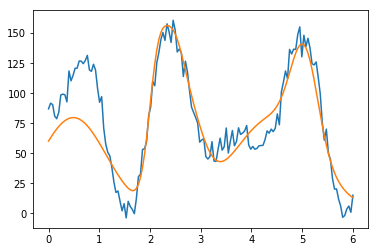

CPU times: user 29min 34s, sys: 7.16 s, total: 29min 41s
Wall time: 29min 49s


In [148]:
%%time
nag_res = nag(f, gradf, x0, 100, 0.000001, 0.1)
print(nag_res)
# nag_res[1]
plt.plot(x, y)
plt.plot(x, radial_fit(x, nag_res[1][:k], nag_res[1][k:2*k], nag_res[1][2*k:], np))
plt.show()

(array([3128962.95030828, 2211818.73580318, 1740747.90018354,
       1395985.26655288, 1180804.4376059 , 1028282.65942247,
        929381.1168978 ,  839167.16311961,  744927.47984962,
        668798.94500111,  587847.1047453 ,  563056.58366643,
        522549.02824129,  486248.32780987,  453217.20752375,
        432225.43968019,  405517.65898174,  388861.85857118,
        366515.99827372,  350247.14485807,  336693.55791579,
        317094.37876744,  303258.77936291,  289895.43554089,
        263365.6072156 ,  245327.29079535,  231977.38108389,
        212120.47961635,  200454.10217938,  189276.81954723,
        178541.47631931,  168259.24876063,  159993.26993323,
        149667.79558336,  142896.17776604,  137371.44188165,
        131850.08989997,  127904.57331574,  123107.43348179,
        119734.41460319,  116081.63495297,  112366.21830047,
        109188.59717043,  106163.13407155,  103719.27462254,
         99112.30441938,   96601.15092909,   94564.38192425,
         92236.07961132

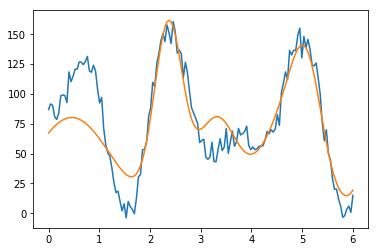

CPU times: user 28min 16s, sys: 1.98 s, total: 28min 18s
Wall time: 28min 20s


In [149]:
%%time
adagrad_res = adagrad(f, gradf, x0, 100, .1)
print(adagrad_res)
plt.plot(x, y)
plt.plot(x, radial_fit(x, adagrad_res[1][:k], adagrad_res[1][k:2*k], adagrad_res[1][2*k:], np))
plt.show()

([3128962.950308283, 2211818.7358026523, 1274995.4964770442, 661845.6172338136, 508751.40895429114, 651530.235795624, 803338.7456882984, 858197.0090529626, 788648.8961846903, 694379.210952813, 614756.6430561721, 561802.8398162395, 468838.95379457047, 367449.92059301987, 273675.6698120438, 194976.2294753748, 157046.74374604295, 155724.58030144594, 180221.05885464625, 218968.35963161523, 262805.08119554527, 295338.57435249566, 298667.6311740466, 283345.14746130235, 265591.28778696846, 245485.2902566091, 217826.0579625515, 184270.7373803018, 149274.67195036754, 116507.29342512628, 88017.92736868454, 64989.58183048361, 50764.149178930194, 44016.50959804313, 45762.051545060625, 51155.80168820253, 58088.887166054876, 63873.83673030254, 64199.07693733305, 60211.821149007614, 55006.98072968759, 48399.2492190776, 42493.216794676286, 37346.47436168294, 34699.56070386939, 33477.29566055219, 34237.780352212925, 35111.118081253284, 35062.597154343784, 33610.021333830395, 32374.469127380326, 31128.7

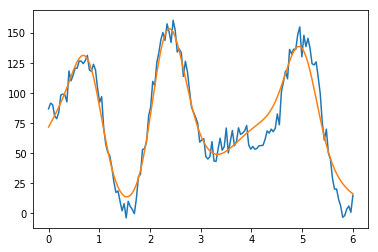

CPU times: user 29min 1s, sys: 3.71 s, total: 29min 5s
Wall time: 29min 9s


In [150]:
%%time
adam_res = adam(f, gradf, x0, 100, 0.1)
print(adam_res)
plt.plot(x, y)
plt.plot(x, radial_fit(x, adam_res[1][:k], adam_res[1][k:2*k], adam_res[1][2*k:], np))
plt.show()